In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
vec = np.ones((100, 100))
tens = torch.tensor(vec, dtype=torch.float32)


In [3]:
tens.shape

torch.Size([100, 100])

In [4]:
tens = tens.unsqueeze(0)
tens = tens.view(100, 1, 100)

In [5]:
m = nn.Conv1d(1, 1, 3, stride=1)
input = tens
output = m(input)

In [6]:
tens

tensor([[[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]]])

In [7]:
output

tensor([[[-0.2668, -0.2668, -0.2668,  ..., -0.2668, -0.2668, -0.2668]],

        [[-0.2668, -0.2668, -0.2668,  ..., -0.2668, -0.2668, -0.2668]],

        [[-0.2668, -0.2668, -0.2668,  ..., -0.2668, -0.2668, -0.2668]],

        ...,

        [[-0.2668, -0.2668, -0.2668,  ..., -0.2668, -0.2668, -0.2668]],

        [[-0.2668, -0.2668, -0.2668,  ..., -0.2668, -0.2668, -0.2668]],

        [[-0.2668, -0.2668, -0.2668,  ..., -0.2668, -0.2668, -0.2668]]],
       grad_fn=<ConvolutionBackward0>)

In [8]:
from PyT_tinymodels import (OneD_UNet, TinyModel, smoother)

In [9]:
device = (
            "cuda"
            if torch.cuda.is_available()
            else "mps"
            if torch.backends.mps.is_available()
            else "cpu"
        )

UNet = OneD_UNet(1,1).to(device)
UNet.load_state_dict(torch.load("/Users/GUSTO/environments/firedrake/src/gusto/learning/unet_poisson.pth"))

Dense = TinyModel().to(device)
Dense.load_state_dict(torch.load("/Users/GUSTO/environments/firedrake/src/gusto/learning/poisson.pth"))

Smoother = smoother().to(device)

sm_kernel = torch.tensor([0.05, 0.075, 0.1, 0.175, 0.2, 0.175, 0.1, 0.075, 0.05], dtype=torch.float32)
smoother = lambda input: F.conv1d(input, sm_kernel.view(1, 1, -1), padding=4)

In [24]:
vec = np.ones((100, 100))
tens = torch.tensor(vec, dtype=torch.float32)

with torch.no_grad():
    out = Dense(tens)
    out = out.unsqueeze(1)
    #print(out.shape)
    out = smoother(out)
    out = smoother(out)
    
Dense_out = torch.Tensor.numpy(out)

tens = tens.unsqueeze(1)
UNet.eval()
with torch.no_grad():
    out = UNet(tens)
UNet_out = torch.Tensor.numpy(out)

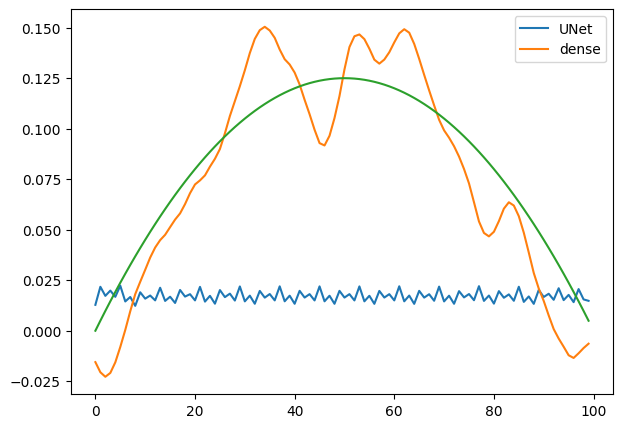

In [25]:
xs = np.arange(100, step=1)
test = (- xs **2 + 100*xs)*0.00005
plt.plot(UNet_out[2][0], label = 'UNet')
plt.plot(Dense_out[2][0], label = 'dense')
plt.plot(test)
plt.legend()

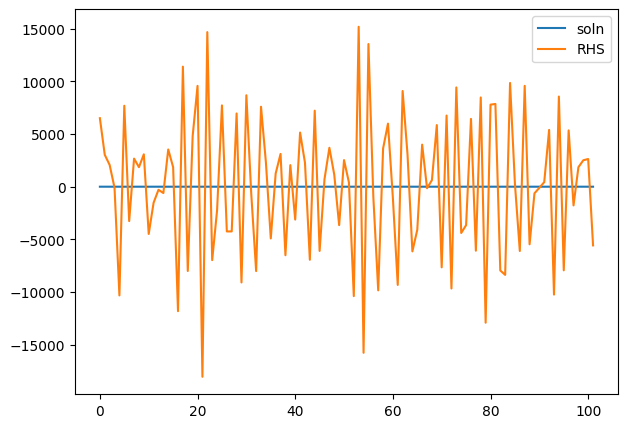

In [26]:
matrix = (2*np.eye(102) - np.eye(102, k=-1) - np.eye(102, k=1))*100**2
#matrix[-1][0] = -1
#matrix[0][-1] = -1
vec_out = np.random.rand(1000, 102)
vec_in = np.dot(vec_out, matrix)
plt.plot(vec_out[0], label = 'soln')
plt.plot(vec_in[0], label = 'RHS')
plt.legend()

In [27]:
xs = np.arange(102, step=1)
a = 0.1 * np.random.randn(1000)
b = 0.05 * np.random.randn(1000)
c = 0.03 * np.random.randn(1000)
d = 0.03 * np.random.randn(1000)
vec_out = np.zeros((1000, 102))
for i in np.arange(1000):
    vec_out[i] = (a[i] * np.sin(np.pi/100 * xs) + b[i] * np.sin(np.pi/100 * 2 * xs) + 
               c[i] * np.sin(np.pi/100 * 3 * xs) + d[i] * np.sin(np.pi/100 * 4 * xs))
    
vec_in = np.dot(vec_out, matrix)

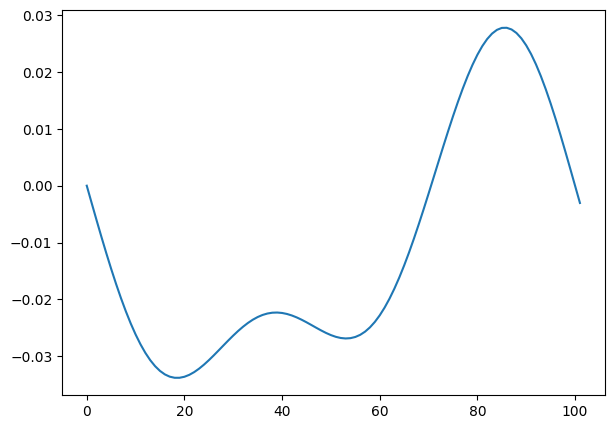

In [30]:
plt.plot(vec_out[100])

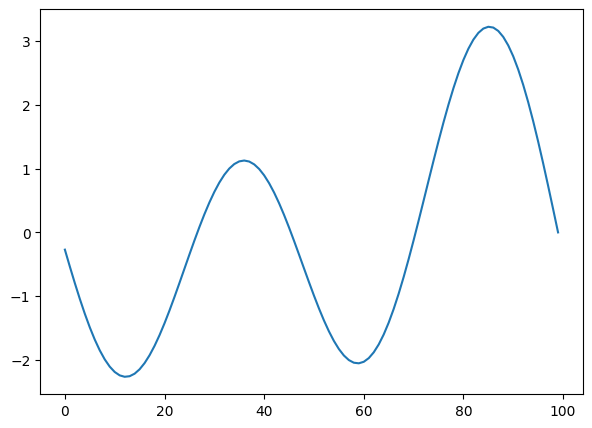

In [31]:
plt.plot(vec_in[100][1:-1])

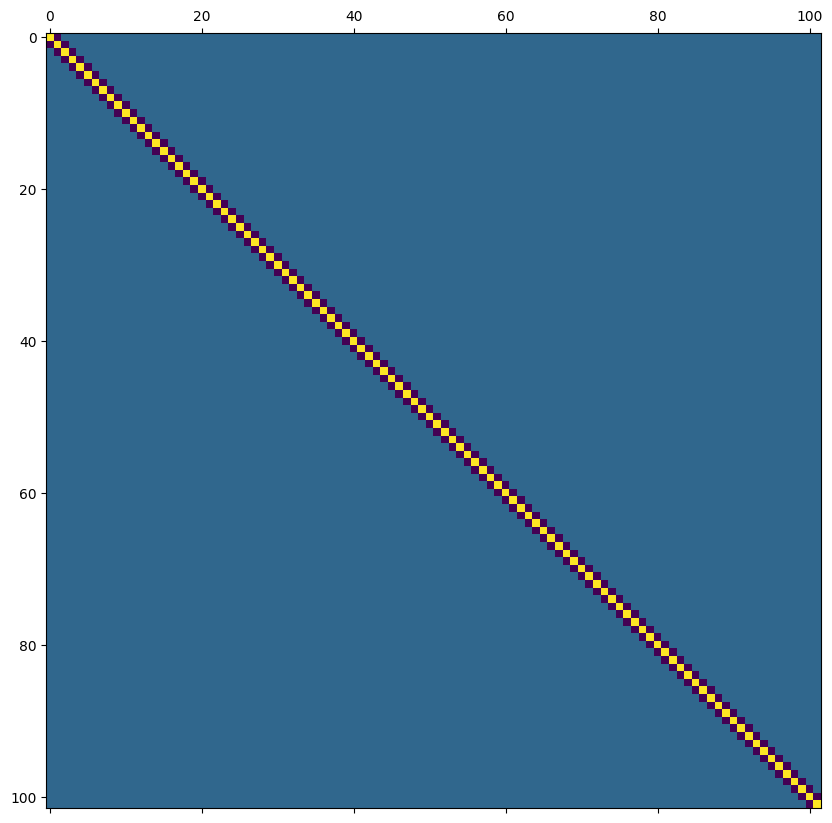

In [32]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.matshow(matrix)
plt.rcParams["figure.figsize"] = [7, 5]

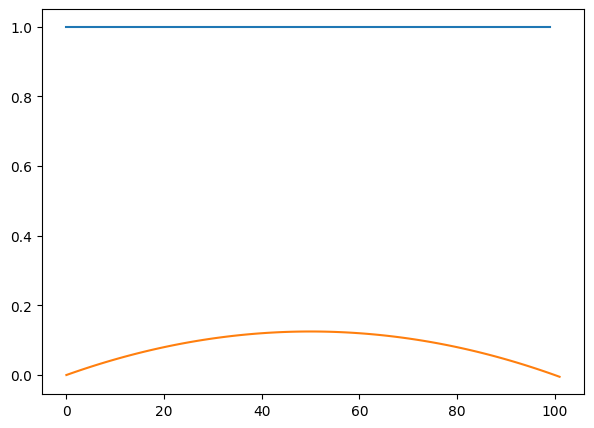

In [33]:
test = (- xs **2 + 100*xs)*0.00005
plt.plot(np.dot(test, matrix)[1:-1])
plt.plot(test)

In [34]:
vec_in = vec_in[:, 1:-1]
vec_out = vec_out[:, 1:-1]

In [35]:
vec_in.shape

(1000, 100)

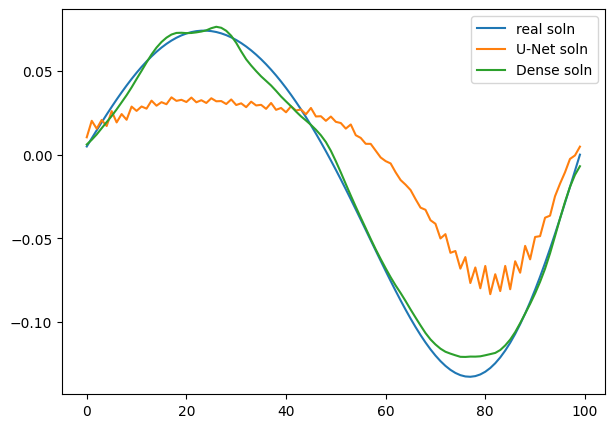

In [36]:
tens = torch.tensor(vec_in[:100, :], dtype=torch.float32)
tens = tens.unsqueeze(1)
UNet.eval()
with torch.no_grad():
    out = UNet(tens)
UNet_out = torch.Tensor.numpy(out)

tens = torch.tensor(vec_in, dtype=torch.float32)
with torch.no_grad():
    out = Dense(tens)
    out = out.unsqueeze(1)
    out = smoother(out)
    out = smoother(out)
Dense_out = torch.Tensor.numpy(out)


fig, ax = plt.subplots()
s = 1
ax.plot(vec_out[s], label = 'real soln')
ax.plot(UNet_out[s][0], label = 'U-Net soln')
ax.plot(Dense_out[s][0], label = 'Dense soln')

ax.legend()